In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL
from PIL import Image
from tensorflow.keras import applications
from tensorflow.keras import optimizers

# Balanced

### Data contains 1200 images (600 normal, 600 pneumonia). 800 will be used for train, 200 for validation, 200 for test

In [2]:
train_dir = r'D:\Diss\Train'
test_dir = r'D:\Diss\Test'
validation_dir = r'D:\Diss\Validation'
imbalanced_dir = r'D:\Diss\Imbalanced'

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(256,256),
                                                   batch_size=20,
                                                   class_mode="binary")

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       target_size=(256,256),
                                                       batch_size=20,
                                                       class_mode="binary")




Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [4]:
def showImage(image):
    image = image*255
    image = np.array(image, dtype=np.uint8)
    print(image)
    if np.ndim(image)>3:
        image = image[0]
    image = PIL.Image.fromarray(image)
    t.show()

In [6]:
def generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((8,8,256)))
    
    model.add(layers.Conv2DTranspose(256,(5,5),strides=(2,2),padding="same",
                                    use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(2,2),padding="same",
                                    use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding="same",
                                    use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32,(5,5),strides=(2,2),padding="same",
                                    use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding="same",
                                    use_bias=False, activation="tanh"))
    return model

In [7]:
g_test = generator()
g_test.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       1638400   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0

### Check if model has been made

In [6]:
vgg = tf.keras.models.load_model(r'D:\Diss\Weights\VGG\Balanced\vgg')

### Make if not

In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

In [9]:
model = tf.keras.applications.VGG19(input_shape = (256,256,3),include_top=False,weights=None)
vgg = tf.keras.models.Sequential()
vgg.add(model)
vgg.add(layers.Flatten())
vgg.add(layers.Dense(512,activation="relu"))
vgg.add(layers.Dense(1,activation="sigmoid"))
vgg.summary()

vgg.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=2e-5),
             metrics=keras.metrics.BinaryAccuracy())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 36,802,625
Trainable params: 36,802,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = vgg.fit(train_generator,
                   steps_per_epoch=40,
                   epochs=30,
                   validation_data=validation_generator,
                   validation_steps=10,
                    callbacks=[early_stop])

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [4]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                 target_size=(256,256),
                                                 class_mode="binary")

def evaluate(model):
    test_loss, test_acc = model.evaluate(test_generator)
    train_loss, train_acc = model.evaluate(train_generator)
    
    print("Test loss: {0}, Test acc: {1} \nTrain loss: {2}, Train acc: {3}".format(test_loss,test_acc,
                                                                                   train_loss, train_acc))

Found 200 images belonging to 2 classes.


In [15]:
evaluate(vgg)

40/40 [==============================] - 12s 270ms/step - loss: 0.0472 - binary_accuracy: 0.98758s - loss
Test loss: 0.3819844722747803, Test acc: 0.875 
Train loss: 0.047201741486787796, Train acc: 0.987500011920929


In [17]:
vgg.save(r'D:\Diss\Weights\VGG\Balanced\vgg')

INFO:tensorflow:Assets written to: D:\Diss\Weights\VGG\Balanced\vgg\assets


### Check for model

In [9]:
res = tf.keras.models.load_model(r'D:\Diss\Weights\RES\Balanced\res')

In [10]:
res_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=False)

In [18]:
model = tf.keras.applications.ResNet50V2(input_shape = (256,256,3),include_top=False,weights=None)
res = tf.keras.models.Sequential()
res.add(model)
res.add(layers.Flatten())
res.add(layers.Dense(512,activation="relu"))
res.add(layers.Dense(1,activation="sigmoid"))
res.summary()

res.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=2e-5),
             metrics=keras.metrics.BinaryAccuracy())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               67109376  
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 90,674,689
Trainable params: 90,629,249
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
historyres = res.fit(train_generator,
                   steps_per_epoch=40,
                   epochs=30,
                   validation_data=validation_generator,
                   validation_steps=10,
                    callbacks=[res_early_stop])

pd.DataFrame(historyres.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [25]:
evaluate(res)

40/40 [==============================] - 11s 257ms/step - loss: 2.9137e-05 - binary_accuracy: 1.0000
Test loss: 0.608567476272583, Test acc: 0.8299999833106995 
Train loss: 2.9137136152712628e-05, Train acc: 1.0


In [26]:
res.save(r'D:\Diss\Weights\RES\Balanced\res')

INFO:tensorflow:Assets written to: D:\Diss\Weights\RES\Balanced\res\assets


C:\Users\Pete\AppData\Roaming\Python\Python38\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [19]:
Inc = tf.keras.models.load_model(r'D:\Diss\Weights\INC\Balanced\inc')

In [27]:
model = tf.keras.applications.InceptionV3(input_shape = (256,256,3),include_top=False,weights=None)
Inc = tf.keras.models.Sequential()
Inc.add(model)
Inc.add(layers.Flatten())
Inc.add(layers.Dense(512,activation="relu"))
Inc.add(layers.Dense(1,activation="sigmoid"))
Inc.summary()

Inc.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=2e-5),
             metrics=keras.metrics.BinaryAccuracy())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               37749248  
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 59,552,545
Trainable params: 59,518,113
Non-trainable params: 34,432
_________________________________________________________________


Epoch 1/30
40/40 [==============================] - 20s 377ms/step - loss: 0.0220 - binary_accuracy: 0.9937 - val_loss: 0.3739 - val_binary_accuracy: 0.9150
Epoch 2/30
40/40 [==============================] - 14s 356ms/step - loss: 0.0210 - binary_accuracy: 0.9937 - val_loss: 0.4735 - val_binary_accuracy: 0.9350
Epoch 3/30
40/40 [==============================] - 14s 346ms/step - loss: 0.0775 - binary_accuracy: 0.9800 - val_loss: 0.6704 - val_binary_accuracy: 0.9300
Epoch 4/30
40/40 [==============================] - 14s 346ms/step - loss: 0.0898 - binary_accuracy: 0.9762 - val_loss: 0.9624 - val_binary_accuracy: 0.9000
Epoch 5/30
40/40 [==============================] - 14s 343ms/step - loss: 0.0590 - binary_accuracy: 0.9850 - val_loss: 0.4521 - val_binary_accuracy: 0.9150
Epoch 6/30
40/40 [==============================] - 14s 348ms/step - loss: 0.0242 - binary_accuracy: 0.9925 - val_loss: 0.3001 - val_binary_accuracy: 0.9400
Epoch 7/30
40/40 [==============================] - 14s 34

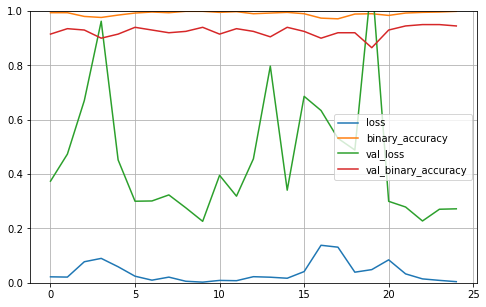

In [20]:
historyInc = Inc.fit(train_generator,
                   steps_per_epoch=40,
                   epochs=30,
                   validation_data=validation_generator,
                   validation_steps=10,
                    callbacks=[early_stop])

pd.DataFrame(historyInc.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show() 

In [21]:
evaluate(Inc)

40/40 [==============================] - 11s 264ms/step - loss: 0.0012 - binary_accuracy: 1.0000
Test loss: 1.0599955320358276, Test acc: 0.8349999785423279 
Train loss: 0.0011626043124124408, Train acc: 1.0


In [23]:
Inc.save(r'D:\Diss\Weights\INC\Balanced\inc')

INFO:tensorflow:Assets written to: D:\Diss\Weights\INC\Balanced\inc\assets


# Imbalanced

### 600 Images consisting of 200 normal and 400 pneumonia

In [5]:
train_imbalanced_datagen = ImageDataGenerator(rescale=1./255)

train_imbalanced_generator = train_imbalanced_datagen.flow_from_directory(imbalanced_dir,
                                                   target_size=(256,256),
                                                   batch_size=20,
                                                   class_mode="binary")

Found 600 images belonging to 2 classes.


In [ ]:
vgg_im = tf.keras.models.load_model("D:\Diss\Weights\VGG\Imbalanced\vgg_im")

Epoch 1/30
30/30 [==============================] - 36s 843ms/step - loss: 0.6660 - binary_accuracy: 0.6667 - val_loss: 0.7250 - val_binary_accuracy: 0.5000
Epoch 2/30
30/30 [==============================] - 12s 406ms/step - loss: 0.6428 - binary_accuracy: 0.6667 - val_loss: 0.7166 - val_binary_accuracy: 0.5000
Epoch 3/30
30/30 [==============================] - 12s 410ms/step - loss: 0.6474 - binary_accuracy: 0.6667 - val_loss: 0.7330 - val_binary_accuracy: 0.5000
Epoch 4/30
30/30 [==============================] - 12s 405ms/step - loss: 0.5778 - binary_accuracy: 0.6883 - val_loss: 0.6832 - val_binary_accuracy: 0.5000
Epoch 5/30
30/30 [==============================] - 12s 411ms/step - loss: 0.3903 - binary_accuracy: 0.8567 - val_loss: 0.3443 - val_binary_accuracy: 0.8950
Epoch 6/30
30/30 [==============================] - 12s 406ms/step - loss: 0.2026 - binary_accuracy: 0.9250 - val_loss: 0.3166 - val_binary_accuracy: 0.8950
Epoch 7/30
30/30 [==============================] - 12s 40

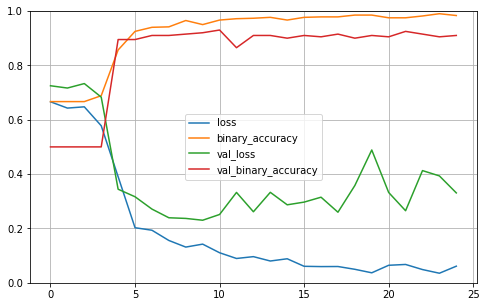

In [13]:
model = tf.keras.applications.VGG19(input_shape = (256,256,3),include_top=False,weights=None)
vgg_im = tf.keras.models.Sequential()
vgg_im.add(model)
vgg_im.add(layers.Flatten())
vgg_im.add(layers.Dense(512,activation="relu"))
vgg_im.add(layers.Dense(1,activation="sigmoid"))

vgg_im.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=2e-5),
             metrics=keras.metrics.BinaryAccuracy())

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
history = vgg_im.fit(train_imbalanced_generator,
                   steps_per_epoch=30,
                   epochs=30,
                   validation_data=validation_generator,
                   validation_steps=10,
                    callbacks=[early_stop])

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [14]:
evaluate(vgg_im)

40/40 [==============================] - 24s 590ms/step - loss: 0.1097 - binary_accuracy: 0.9675
Test loss: 0.4129546284675598, Test acc: 0.8500000238418579 
Train loss: 0.10972023010253906, Train acc: 0.9674999713897705


In [15]:
vgg_im.save(r'D:\Diss\Weights\VGG\Imbalanced\vgg_im')

INFO:tensorflow:Assets written to: D:\Diss\Weights\VGG\Imbalanced\vgg_im\assets


In [ ]:
res_im = tf.keras.models.load_model(r'D:\Diss\Weights\RES\Imbalanced\res_im')

In [6]:
model = tf.keras.applications.ResNet50V2(input_shape = (256,256,3),include_top=False,weights=None)
res_im = tf.keras.models.Sequential()
res_im.add(model)
res_im.add(layers.Flatten())
res_im.add(layers.Dense(512,activation="relu"))
res_im.add(layers.Dense(1,activation="sigmoid"))
res_im.summary()

res_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=False)

res_im.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=2e-5),
             metrics=keras.metrics.BinaryAccuracy())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               67109376  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 90,674,689
Trainable params: 90,629,249
Non-trainable params: 45,440
_________________________________________________________________


Epoch 1/30
30/30 [==============================] - 10s 339ms/step - loss: 3.8100e-04 - binary_accuracy: 1.0000 - val_loss: 2.4178 - val_binary_accuracy: 0.5000
Epoch 2/30
30/30 [==============================] - 10s 328ms/step - loss: 9.0962e-04 - binary_accuracy: 1.0000 - val_loss: 2.0498 - val_binary_accuracy: 0.5150
Epoch 3/30
30/30 [==============================] - 10s 327ms/step - loss: 9.3857e-04 - binary_accuracy: 1.0000 - val_loss: 1.0151 - val_binary_accuracy: 0.6500
Epoch 4/30
30/30 [==============================] - 10s 334ms/step - loss: 5.1292e-04 - binary_accuracy: 1.0000 - val_loss: 1.0527 - val_binary_accuracy: 0.6800
Epoch 5/30
30/30 [==============================] - 10s 339ms/step - loss: 3.1699e-04 - binary_accuracy: 1.0000 - val_loss: 0.7250 - val_binary_accuracy: 0.7650
Epoch 6/30
30/30 [==============================] - 10s 340ms/step - loss: 8.1141e-04 - binary_accuracy: 1.0000 - val_loss: 0.6678 - val_binary_accuracy: 0.7900
Epoch 7/30
30/30 [================

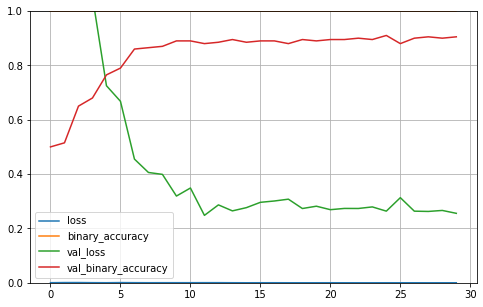

In [8]:
historyres = res_im.fit(train_imbalanced_generator,
                   steps_per_epoch=30,
                   epochs=30,
                   validation_data=validation_generator,
                   validation_steps=10,
                    callbacks=[res_early_stop])

pd.DataFrame(historyres.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [9]:
evaluate(res_im)

40/40 [==============================] - 19s 463ms/step - loss: 0.0851 - binary_accuracy: 0.9725
Test loss: 0.9628458619117737, Test acc: 0.75 
Train loss: 0.08511199802160263, Train acc: 0.9725000262260437


In [10]:
res_im.save(r'D:\Diss\Weights\RES\Imbalanced\res_im')

INFO:tensorflow:Assets written to: D:\Diss\Weights\RES\Imbalanced\res_im\assets


C:\Users\Pete\AppData\Roaming\Python\Python38\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [25]:
Inc_im = tf.keras.models.load_model(r'D:\Diss\Weights\INC\Imbalanced\inc_im')

In [11]:
model = tf.keras.applications.InceptionV3(input_shape = (256,256,3),include_top=False,weights=None)
Inc_im = tf.keras.models.Sequential()
Inc_im.add(model)
Inc_im.add(layers.Flatten())
Inc_im.add(layers.Dense(512,activation="relu"))
Inc_im.add(layers.Dense(1,activation="sigmoid"))
Inc_im.summary()

Inc_im.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=2e-5),
             metrics=keras.metrics.BinaryAccuracy())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               37749248  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 59,552,545
Trainable params: 59,518,113
Non-trainable params: 34,432
_________________________________________________________________


Epoch 1/30
30/30 [==============================] - 10s 330ms/step - loss: 0.1143 - binary_accuracy: 0.9783 - val_loss: 5.7484 - val_binary_accuracy: 0.5000
Epoch 2/30
30/30 [==============================] - 10s 326ms/step - loss: 0.7960 - binary_accuracy: 0.8717 - val_loss: 4.7612 - val_binary_accuracy: 0.5000
Epoch 3/30
30/30 [==============================] - 10s 334ms/step - loss: 0.2134 - binary_accuracy: 0.9533 - val_loss: 4.4556 - val_binary_accuracy: 0.5000
Epoch 4/30
30/30 [==============================] - 10s 331ms/step - loss: 0.0614 - binary_accuracy: 0.9783 - val_loss: 2.7515 - val_binary_accuracy: 0.5050
Epoch 5/30
30/30 [==============================] - 10s 332ms/step - loss: 0.0342 - binary_accuracy: 0.9867 - val_loss: 2.3891 - val_binary_accuracy: 0.5150
Epoch 6/30
30/30 [==============================] - 10s 330ms/step - loss: 0.0087 - binary_accuracy: 1.0000 - val_loss: 1.6803 - val_binary_accuracy: 0.5700
Epoch 7/30
30/30 [==============================] - 10s 33

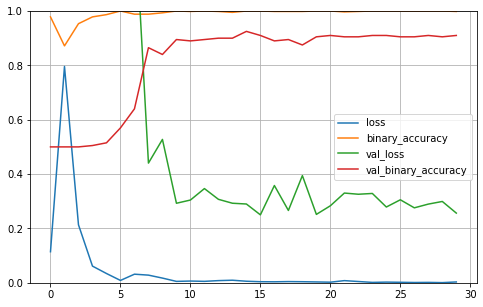

In [17]:
historyInc = Inc_im.fit(train_imbalanced_generator,
                   steps_per_epoch=30,
                   epochs=30,
                   validation_data=validation_generator,
                   validation_steps=10,
                    callbacks=[res_early_stop])

pd.DataFrame(historyInc.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show() 

In [26]:
evaluate(Inc_im)

40/40 [==============================] - 17s 413ms/step - loss: 0.0529 - binary_accuracy: 0.9862
Test loss: 0.6778191328048706, Test acc: 0.8299999833106995 
Train loss: 0.05286611244082451, Train acc: 0.9862499833106995


In [24]:
Inc_im.save(r'D:\Diss\Weights\INC\Imbalanced\inc_im')

INFO:tensorflow:Assets written to: D:\Diss\Weights\INC\Imbalanced\inc_im\assets
